## **Efficient Memory Management for Large Language Model Serving with PagedAttention**

Kwon, W., Li, Z., Zhuang, S., Sheng, Y., Zheng, L., Yu, C. H., Gonzalez, J., Zhang, H., & Stoica, I. (2023). Efficient Memory Management for Large Language Model Serving with PagedAttention. Proceedings of the 29th Symposium on Operating Systems Principles, 611–626. https://doi.org/10.1145/3600006.3613165

In this notebook, we conduct three experiments to show:
1. Effect of KV caching on transformer generation speed
2. Transformer generation speed using KV Caching with PagedAttention vs. KV caching only
3. Transformer beam search generation speed and memory requirement using KV Caching with PagedAttention vs. KV caching only

We show that KV caching can improve token generation speed compared to naive self-attention. We also show that PageAttention can further increase token generation speed compared to KV caching on its own. Finally, we show PagedAttention can efficiently manage memory to achive beam search decoding with a higher beam width compared to vanilla KV caching under the same GPU memory constraint.

In [ ]:
!pip install vllm
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/

In [ ]:
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from vllm import LLM
from vllm import SamplingParams
from datasets import load_dataset
from vllm.sampling_params import BeamSearchParams

INFO 03-21 06:01:19 [__init__.py:256] Automatically detected platform cuda.


### **1. Transformer generation speed with vs. without KV caching**

Inspired by the experiment in

Lages, J. (2023, October 8). Transformers KV Caching Explained. Medium. https://medium.com/@joaolages/kv-caching-explained-276520203249

This experiment compares the generation speed when using KV caching vs. without using KV caching. We test this using different numbers of max output tokens. At lower max tokens, we see little difference in generation speed between using and not using KV caching. However, as the number of max tokens increase, we notice that the amount of time it takes to generate tokens without KV caching significantly increases, while token generation with KV caching maintains a stable generation speed.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

# Different max_new_tokens values to test
max_tokens_values = [50, 100, 200, 300, 400, 500, 600, 800, 1000]

# Store results
results = {"with_cache": [], "without_cache": []}
std_devs = {"with_cache": [], "without_cache": []}

for use_cache in (True, False):
    for max_tokens in max_tokens_values:
        times = []
        for _ in range(5):  # measuring 5 generations
            start = time.time()
            outputs = model.generate(
                **tokenizer("What is KV caching?", return_tensors="pt").to(device),
                use_cache=use_cache, max_new_tokens=max_tokens
            )
            elapsed_time = time.time() - start
            total_tokens = outputs.numel()

            # Calculate time per token
            time_per_token = elapsed_time / total_tokens
            times.append(time_per_token)

        avg_time = np.mean(times)
        std_time = np.std(times)
        key = "with_cache" if use_cache else "without_cache"
        results[key].append(avg_time)
        std_devs[key].append(std_time)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
del model
torch.cuda.empty_cache()

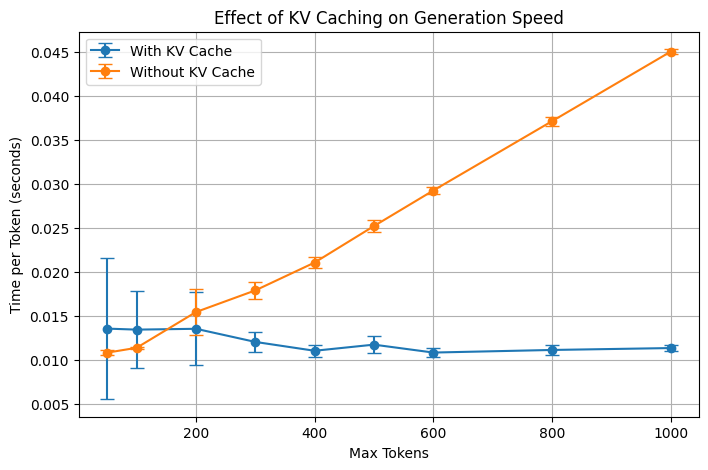

In [ ]:
# Plot results
plt.figure(figsize=(8, 5))
plt.errorbar(max_tokens_values, results["with_cache"], yerr=std_devs["with_cache"], fmt='-o', label='With KV Cache', capsize=5)
plt.errorbar(max_tokens_values, results["without_cache"], yerr=std_devs["without_cache"], fmt='-o', label='Without KV Cache', capsize=5)
plt.xlabel("Max Tokens")
plt.ylabel("Time per Token (seconds)")
plt.title("Effect of KV Caching on Generation Speed")
plt.legend()
plt.grid()
plt.show()

### **2. Transformer generation speed using KV Caching with PagedAttention vs. KV Caching only**

This experiment compares the generation speed when using KV caching with PagedAttention vs. KV caching only. We test this using different numbers of input prompts. We see that PagedAttention consistently decreases the time it takes to generate tokens compared to vanilla KV caching.

In [ ]:
ds = load_dataset("MohamedRashad/ChatGPT-prompts")
prompts_full = ds["train"]["human_prompt"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# batch sizes of different numbers of prompts
batch_sizes = [10, 20, 30, 50, 70, 90]

In [ ]:
# KV caching with PagedAttention
paged_attention_times = []

# create model using vLLM
llm = LLM(model="gpt2", seed=123)

# set the max tokens generated to be constant
sampling_params = SamplingParams(temperature=0.7, top_p=0.9, max_tokens=900)

for batch_size in batch_sizes:
    prompts = prompts_full[:batch_size]
    start = time.time()
    outputs = llm.generate(prompts, sampling_params)
    elapsed_time = time.time() - start

    total_tokens = sum(len(output.outputs[0].token_ids) for output in outputs)
    # Calculate time per token
    time_per_token = elapsed_time / total_tokens
    paged_attention_times.append(time_per_token)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

INFO 03-20 19:18:25 [config.py:2595] Downcasting torch.float32 to torch.float16.
INFO 03-20 19:18:39 [config.py:583] This model supports multiple tasks: {'embed', 'generate', 'classify', 'reward', 'score'}. Defaulting to 'generate'.
WARNING 03-20 19:18:39 [arg_utils.py:1765] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 03-20 19:18:39 [llm_engine.py:241] Initializing a V0 LLM engine (v0.8.1) with config: model='gpt2', speculative_config=None, tokenizer='gpt2', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=1024, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar', reasoning_backend=None), observabi

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

INFO 03-20 19:18:43 [cuda.py:234] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 03-20 19:18:43 [cuda.py:282] Using XFormers backend.
INFO 03-20 19:18:44 [parallel_state.py:967] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 03-20 19:18:44 [model_runner.py:1110] Starting to load model gpt2...
INFO 03-20 19:18:45 [weight_utils.py:257] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

INFO 03-20 19:18:48 [weight_utils.py:273] Time spent downloading weights for gpt2: 3.439051 seconds
INFO 03-20 19:18:49 [weight_utils.py:307] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-20 19:18:49 [loader.py:429] Loading weights took 0.44 seconds
INFO 03-20 19:18:49 [model_runner.py:1146] Model loading took 0.2378 GB and 4.555680 seconds
INFO 03-20 19:18:51 [worker.py:267] Memory profiling takes 1.14 seconds
INFO 03-20 19:18:51 [worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.90) = 13.27GiB
INFO 03-20 19:18:51 [worker.py:267] model weights take 0.24GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.49GiB; the rest of the memory reserved for KV Cache is 12.51GiB.
INFO 03-20 19:18:51 [executor_base.py:111] # cuda blocks: 22772, # CPU blocks: 7281
INFO 03-20 19:18:51 [executor_base.py:116] Maximum concurrency for 1024 tokens per request: 355.81x
INFO 03-20 19:18:56 [model_runner.py:1442] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]

INFO 03-20 19:19:30 [model_runner.py:1570] Graph capturing finished in 33 secs, took 0.14 GiB
INFO 03-20 19:19:30 [llm_engine.py:447] init engine (profile, create kv cache, warmup model) took 40.41 seconds



Processed prompts: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s, est. speed input: 40.67 toks/s, output: 1723.94 toks/s]


In [ ]:
del llm
torch.cuda.empty_cache()

In [ ]:
# KV caching only
kv_caching_times = []
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
tokenizer.pad_token = tokenizer.eos_token

for batch_size in batch_sizes:
    prompts = prompts_full[:batch_size]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, padding_side='left').to(device)

    start = time.time()
    outputs = model.generate(**inputs, use_cache=True, max_new_tokens=900)
    elapsed_time = time.time() - start

    total_tokens = outputs.numel()
    # Calculate time per token
    time_per_token = elapsed_time / total_tokens
    kv_caching_times.append(time_per_token)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
del model
torch.cuda.empty_cache()

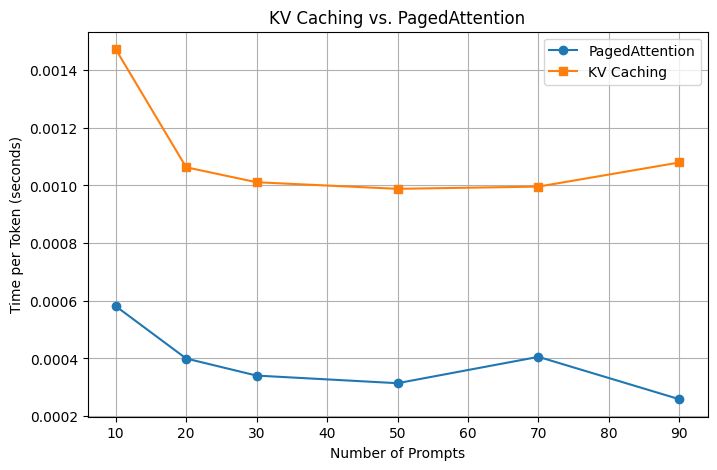

In [ ]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(batch_sizes, paged_attention_times, marker='o', label='PagedAttention')
plt.plot(batch_sizes, kv_caching_times, marker='s', label='KV Caching')
plt.xlabel('Number of Prompts')
plt.ylabel('Time per Token (seconds)')
plt.title('KV Caching vs. PagedAttention')
plt.legend()
plt.grid()
plt.show()

### **3. Transformer beam search generation speed and memory requirement using KV Caching with PagedAttention vs. KV caching only**

This experiment compares the generation speed when using beam search with and without PagedAttention and with different beam widths, We find the generation speed is significantly faster when using the HuggingFace library's beam search function (proxy for the without PagedAttention condition); however, we find Paged Attention could perform beam search with higher beam widths given the same GPU memory constraint.

In [ ]:
prompts = prompts_full[:30]

hf_gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
hf_gpt2_tokenizer.pad_token = hf_gpt2_tokenizer.eos_token   # gpt2 does not have a pad token, use eos
hf_gpt2_tokenizer.padding_side = "left"   # use left-padding
hf_gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").to('cuda')
hf_results = []

# Tokenize all prompts in a batch
prompt_tokens = hf_gpt2_tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

# Generate responses for the batch
for n_beams in [2, 4, 6, 8]:
  start = time.time()
  outputs = hf_gpt2.generate(
      **prompt_tokens,
      num_beams=n_beams,
      num_return_sequences=n_beams,
      max_length=500,
  )
  total_tokens = outputs.numel()
  time_taken = time.time() - start
  sec_per_token = time_taken / total_tokens
  hf_results.append({"num_beams": n_beams,
                     "time": time_taken,
                     "total_tokens": total_tokens,
                     "sec_per_token": sec_per_token})
  print(f"Hugging Face GPT-2 with Beam Search (num_beams={n_beams}): {time_taken/total_tokens} seconds/token, time: {time_taken} seconds.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hugging Face GPT-2 with Beam Search (num_beams=2): 0.001016769536336263 seconds/token, time: 30.50308609008789 seconds.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hugging Face GPT-2 with Beam Search (num_beams=4): 0.0009551970402399699 seconds/token, time: 57.31182241439819 seconds.


OutOfMemoryError: CUDA out of memory. Tried to allocate 200.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 140.12 MiB is free. Process 241262 has 14.60 GiB memory in use. Of the allocated memory 14.10 GiB is allocated by PyTorch, and 386.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
prompts = prompts_full[:30]

vllm_gpt2 = LLM(model="gpt2", seed=123)
vllm_results = []

# Generate responses for the batch
for n_beams in [2, 4, 6, 8]:
  sampling_params = BeamSearchParams(beam_width=n_beams, max_tokens=500)
  start = time.time()
  outputs = vllm_gpt2.beam_search([{"prompt": prompt} for prompt in prompts], sampling_params)
  total_tokens = sum(len(seq.tokens) for obj in outputs for seq in obj.sequences)
  time_taken = time.time() - start
  sec_per_token = time_taken / total_tokens
  vllm_results.append({"num_beams": n_beams,
                     "time": time_taken,
                     "total_tokens": total_tokens,
                     "sec_per_token": sec_per_token})
  print(f"vLLM GPT-2 with Beam Search (num_beams={n_beams}): {time_taken/total_tokens}:2f seconds/token, time: {time_taken} seconds.")

INFO 03-21 06:01:24 [config.py:2595] Downcasting torch.float32 to torch.float16.
INFO 03-21 06:01:42 [config.py:583] This model supports multiple tasks: {'reward', 'generate', 'classify', 'score', 'embed'}. Defaulting to 'generate'.
WARNING 03-21 06:01:42 [arg_utils.py:1765] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 03-21 06:01:42 [llm_engine.py:241] Initializing a V0 LLM engine (v0.8.1) with config: model='gpt2', speculative_config=None, tokenizer='gpt2', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=1024, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar', reasoning_backend=None), observabi

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-21 06:01:46 [loader.py:429] Loading weights took 0.44 seconds
INFO 03-21 06:01:46 [model_runner.py:1146] Model loading took 0.2378 GB and 1.131871 seconds
INFO 03-21 06:01:48 [worker.py:267] Memory profiling takes 1.04 seconds
INFO 03-21 06:01:48 [worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.90) = 13.27GiB
INFO 03-21 06:01:48 [worker.py:267] model weights take 0.24GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.47GiB; the rest of the memory reserved for KV Cache is 12.53GiB.
INFO 03-21 06:01:49 [executor_base.py:111] # cuda blocks: 22815, # CPU blocks: 7281
INFO 03-21 06:01:49 [executor_base.py:116] Maximum concurrency for 1024 tokens per request: 356.48x
INFO 03-21 06:01:55 [model_runner.py:1442] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:38<00:00,  1.11s/it]

INFO 03-21 06:02:34 [model_runner.py:1570] Graph capturing finished in 39 secs, took 0.14 GiB
INFO 03-21 06:02:34 [llm_engine.py:447] init engine (profile, create kv cache, warmup model) took 47.64 seconds


vLLM GPT-2 with Beam Search (num_beams=2): 0.004905143373045945:2f seconds/token, time: 151.95153141021729 seconds.
vLLM GPT-2 with Beam Search (num_beams=4): 0.004104742746776236:2f seconds/token, time: 257.95845317840576 seconds.
vLLM GPT-2 with Beam Search (num_beams=6): 0.004144250384167544:2f seconds/token, time: 388.8425807952881 seconds.
vLLM GPT-2 with Beam Search (num_beams=8): 0.004294117706916569:2f seconds/token, time: 535.9660074710846 seconds.


$$\textbf{Table 1: Effect of Paged Attention on Beam Search Inference Time (s) with Different Beam Widths (batch size=30)}$$

$$
\begin{array}{|c|c|c|c|c|}
\hline
 & \text{beam width=2} & \text{beam width=4} & \text{beam width=6} & \text{beam width=8} \\
\hline
\text{Without Paged Attention} & 30.5 & 57.3 & \text{OOM} & \text{OOM}  \\
\hline
\text{With Paged Attention} & 152 & 258 & 389 & 536  \\
\hline
\end{array}
$$